In [175]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict 
import parse_hipnogram as ph
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import sklearn.metrics as metrics
from matplotlib.dates import  DateFormatter
import seaborn as sns
from datetime import timedelta
plt.rcParams['figure.figsize'] = (9.0, 5.0)
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')

from statsmodels.stats.inter_rater import cohens_kappa, to_table
import nbimporter
from Time_synchronization import get_hipnogram_intersection 
labels = ['rem','N1', 'N2', 'N3','wake']

stage_to_num = {'W':5, 'R':1, 'N1':2 , 'N2':3, 'N3':4 }
dummy_dict = {'stage_1': 'rem', 'stage_2' : 'N1', 'stage_3' : 'N2', 'stage_4': 'N3', 'stage_5':'wake'}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
# load hipnograms, resample them and select their common time window

psg_hipnogram = ph.parse_psg_stages().resample('1s').fillna(method = 'ffill')
neuroon_hipnogram = ph.parse_neuroon_stages().resample('1s').fillna(method = 'ffill')

# Get the start and end of the time window covered by both hipnograms
start = neuroon_hipnogram.index.searchsorted(psg_hipnogram.index.get_values()[0])
end = psg_hipnogram.index.searchsorted(neuroon_hipnogram.index.get_values()[-1])

# Trim hipnograms to the common time window so the confusion matrix calculations are accurate
# +1 and -1 because events got cut in half, resulting in ends without starts
neuroon_hipnogram = neuroon_hipnogram.ix[start ::]
# +1 because upper bound is not included
psg_hipnogram = psg_hipnogram.ix[0:end +1]

In [166]:
def binarize_stages(hipnogram):
    return pd.get_dummies(hipnogram, prefix = 'stage')

In [168]:
# make a confusion matrix for each stage (binarized: stage = 1, all_other = 0)
def confusion_matrix_separate():
    # TODO, neuroon stages saved as float, change to int upstream
    neuroon_binarized = binarize_stages(neuroon_hipnogram['stage_num'].astype(int))
    psg_binarized = binarize_stages(psg_hipnogram['stage_num'])
    
    fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize = (8,8))
    for neuroon_stage, ax in zip(neuroon_binarized, axes.reshape(-1)):
        stage_true = neuroon_binarized[neuroon_stage].as_matrix()
        stage_predicted = psg_binarized[neuroon_stage].as_matrix()
        cm = confusion_matrix(stage_true, stage_predicted)
        

        sns.heatmap(cm, annot = True, xticklabels = ['yes','no'],  yticklabels = ['yes','no'],fmt = '.0f', ax = ax)
        
        ax.set_title(dummy_dict[neuroon_stage])
        ax.set_ylabel('psg')
        ax.set_xlabel('neuroon')
        fig.tight_layout()

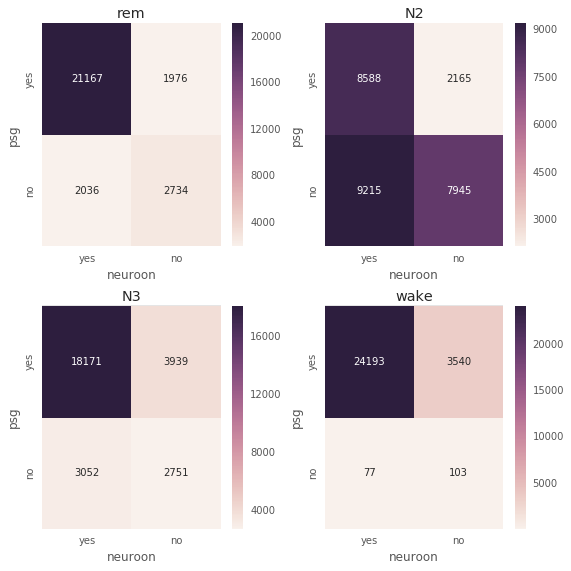

In [169]:
confusion_matrix_separate()

In [176]:
def calc_times(hipno):
    
    stage_durations = OrderedDict()

    for name, sleep_stage in hipno.groupby('stage_name'):
    
        for idx, stage_event in sleep_stage.iterrows():
            duration = (stage_event['ends'] -  stage_event['starts']).total_seconds()
            
            if stage_event['stage_name'] not in stage_durations.keys():
                # Divide to get minutes
                stage_durations[stage_event['stage_name']] = duration
            else:
                stage_durations[stage_event['stage_name']] += duration
    
    
    return stage_durations

def get_hipnogram_intersection(neuroon_hipnogram, psg_hipnogram, time_shift):
    # Shift the hipnogram by time in seconds defined by 'time_shift' (can be negative) 
    neuroon_hipnogram.index = neuroon_hipnogram.index + timedelta(seconds = int(time_shift))
    
    # Join the two hipnograms. 
    # Because they are indexed with datetime the join will insert the rows of neuroon inbetween psg hipnograms
    # in the corresponding times.
    # Joining keeps original columns from both data frames
    # new rows with nans in one of two original sets of columns will be inserted where indexes do not overlap (which is everywhere)
    combined = psg_hipnogram.join(neuroon_hipnogram, how = 'outer', lsuffix = '_psg', rsuffix = '_neuro')
    
    # These nan rows will always occur between start and end of a sleep stage, so can be filled used bfill or ffill.
    combined.loc[:, ['stage_num_psg', 'stage_name_psg', 'stage_num_neuro', \
                     'stage_name_neuro','event_number_psg', 'event_number_neuro']] = \
                combined.loc[:, ['stage_num_psg', 'stage_name_psg', 'stage_num_neuro', \
                                 'stage_name_neuro', 'event_number_psg', 'event_number_neuro']]\
                                .fillna( method = 'bfill')        
    # Mark when a sleep stage defined by start and end gets new rows inserted inbetween.
    # New rows are inserted when inbetween of start and end of stage recorded by one device, another device recorded start or end of a sleep stage
    combined.loc[:, ['stage_shift_psg', 'stage_shift_neuro']] = \
                combined.loc[:, ['stage_shift_psg', 'stage_shift_neuro']].fillna( value = 'inside')      
    
    # From the sleep stage identified by psg subtract the sleep stage according to neuroon.
    combined['overlap'] = combined['stage_num_psg'] - combined['stage_num_neuro']
    
    # Find rows where two devices identified the same stage
    same_stage = combined.loc[combined['overlap'] == 0]
    # Mark each occurence of same stage period with unique id number (event union)
    same_stage.loc[:, 'event_union'] = same_stage['event_number_psg'] + same_stage['event_number_neuro']
    
    # prepare dict to save a list of all overlaps durations per stage (key)
    all_durations = OrderedDict()
    
    # groupby event union, which will result in a dataframe with two rows,
    # first row is the startt and second row is the end of the overlap event.
    for stage_name, intersection in same_stage.groupby('event_union'):
            
            # Subtract the first row timestamp from the last to get the duration. 
            # Store as the duration in seconds.
            duration = (intersection.index.to_series().iloc[-1]- intersection.index.to_series().iloc[0])\
            .total_seconds()
            
            # get at which stage overlap happened                    
            stage_id = intersection.iloc[0, intersection.columns.get_loc('stage_name_neuro')] 
            
            # Keep appending overlap durations to a list stored in a dict. Check if the list exists, if not create it.
            if stage_id not in all_durations.keys():
                all_durations[stage_id] = [duration]
                
            else:   
                all_durations[stage_id].append(duration)
            

    # Calculate some statistics of the overlaps
    means = OrderedDict()
    stds = OrderedDict()
    sums = OrderedDict()
    stages_sum = 0
    
    #Adding it here so it is first item in ordered dict thus plotted on the left end.
    sums['stages_sum'] = 0
    # iterate over lists of overlap durations stored under stage name keys
    for key, value in all_durations.items():
        # Compute their statistics
        means[key] = np.array(value).mean()
        stds[key] = np.array(value).std()
        sums[key] = np.array(value).sum()
        # And the sum from all stages (i.e. not split between stages)
        stages_sum += np.array(value).sum()   
    
    sums['stages_sum'] = stages_sum
    
    return sums, means, stds

psg_hipno = ph.parse_psg_stages()
noo_hipno = ph.parse_neuroon_stages()

# Get the start and end of the time window covered by both hipnograms
start = noo_hipno.index.searchsorted(psg_hipno.index.get_values()[0])
end = psg_hipno.index.searchsorted(noo_hipno.index.get_values()[-1])

# Trim hipnograms to the common time window so the confusion matrix calculations are accurate
# +1 and -1 because events got cut in half, resulting in ends without starts
noo_hipno = noo_hipno.ix[start +1::]
psg_hipno = psg_hipno.ix[0:end -1]

psg_total = calc_times(ph.prep_for_phases(psg_hipno.copy()))
neuroon_total= calc_times(ph.prep_for_phases(noo_hipno.copy()))

neuroon_correct, _, _ = get_hipnogram_intersection(psg_hipno.copy(), noo_hipno.copy(), 0)

In [177]:
neuroon_correct

OrderedDict([('stages_sum', 13703.931999999999),
             ('wake', 263.99799999999999),
             ('N2', 7949.9529999999995),
             ('N3', 2753.9899999999998),
             ('rem', 2735.991)])

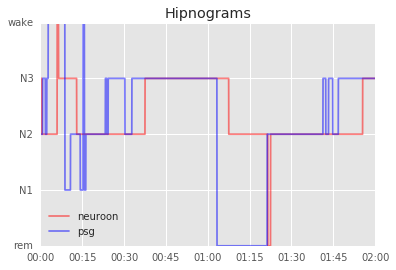

In [66]:

fig, axes = plt.subplots()
axes.set_title('Hipnograms')

start = '00:00'
end = '02:00'


# Select a time window
neuroon_cut = neuroon_hipnogram.between_time(start, end)
psg_cut = psg_hipnogram.between_time(start, end)


# plot the original hipnograms
axes.plot(neuroon_cut.index, neuroon_cut['stage_num'], color = 'r', alpha = 0.5, label ='neuroon')
axes.plot(psg_cut.index, psg_cut['stage_num'], color = 'b', alpha = 0.5, label ='psg')

# Format the figure
#for ax in axes:
axes.legend(loc = 'lower left')
axes.set_yticks([1,2,3,4,5])
axes.set_yticklabels(['rem','N1', 'N2', 'N3','wake'])
axes.xaxis.set_major_formatter( DateFormatter('%H:%M') )

In [67]:
stage_true = psg_hipnogram['stage_num'].as_matrix()
stage_predicted = neuroon_hipnogram['stage_num'].as_matrix()

In [68]:
cf = confusion_matrix(stage_true, stage_predicted)


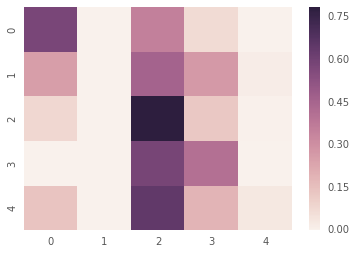

In [69]:
cf_normalized = cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]
sns.heatmap(cf_normalized)

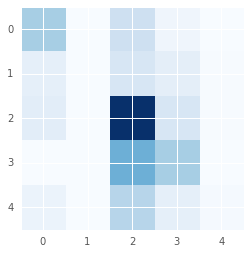

In [70]:
plt.imshow(cf, interpolation='nearest', cmap=plt.cm.Blues)


In [71]:
#sklearn function
cohen_kappa_score(stage_true, stage_predicted)

0.26175025493078574

In [72]:
# statsmodel function
cohens_kappa(cf)

{'alpha': 0.025,
 'alpha_ci': '  95',
 'distribution_kappa': <scipy.stats._distn_infrastructure.rv_frozen at 0x11116bb10>,
 'distribution_zero_null': <scipy.stats._distn_infrastructure.rv_frozen at 0x11158af10>,
 'kappa': 0.26175025493078574,
 'kappa_low': 0.2542568894745843,
 'kappa_max': 0.63498221923212017,
 'kappa_upp': 0.26924362038698718,
 'kind': 'Simple',
 'pvalue_one_sided': 0.0,
 'pvalue_two_sided': 0.0,
 'std_kappa': 0.0038232158934083204,
 'std_kappa0': 0.0032517942651247738,
 'var_kappa': 1.4616979767609981e-05,
 'var_kappa0': 1.0574165942698368e-05,
 'weights': None,
 'z_value': 80.49410066867874}

In [75]:
y = metrics.classification_report(stage_true, stage_predicted, target_names = labels )

In [76]:
print(y)

             precision    recall  f1-score   support

        rem       0.57      0.58      0.58      4710
         N1       0.00      0.00      0.00      2760
         N2       0.46      0.79      0.58     10110
         N3       0.47      0.41      0.44      6690
       wake       0.57      0.03      0.05      3643

avg / total       0.45      0.48      0.42     27913

